# **Data @ ANZ - Predictive Analytics**
This notebook contains code and visualisations required to decipher correlations between the dataset attributes, calculate the annual salaries of customers, and build regression and decision tree models for predicting the annual salary of a customer

Note : The dataset contains geographical attributes(long_lat and merchant_long_lat) that had been split into latitudinal and longitudinal measures in Excel.

Libraries Used - Pandas, Numpy, Sklearn, Seaborn, Matplotlib

# Importing the dataset

In [1]:
import pandas as pd
import numpy as np

file = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data/ANZ synthesised transaction dataset_clean.xlsx")

file.head(5)

,status,card_present_flag,bpay_biller_code,account,currency,longitude,latitude,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_longitude,merchant_latitude,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41,-27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01 01:01:15,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38,-27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41,-27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01 01:13:45,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21,-33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23,-33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01 01:26:15,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21,-33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10,-27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01 01:38:45,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05,-26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41,-27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01 01:51:15,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44,-28.06,debit


# Data Pre-Processing

**Filtering irrelevant attributes and rows out of the subset of the dataset to analyse the salaries**

In [2]:
file = file[file['txn_description']=="PAY/SALARY"]

del file['currency']
del file['country']
del file['merchant_latitude']
del file['merchant_longitude']
del file['merchant_id']
del file['merchant_code']
del file['transaction_id']
del file['merchant_state']
del file['merchant_suburb']
del file['card_present_flag']

file = file.drop(['txn_description','status','movement'],axis=1)
file.head()

,bpay_biller_code,account,longitude,latitude,first_name,balance,date,gender,age,extraction,amount,customer_id
50,0,ACC-588564840,151.27,-33.76,Isaiah,8342.11,2018-08-01,M,23,2018-08-01 11:00:00,3903.95,CUS-1462656821
61,0,ACC-1650504218,145.01,-37.93,Marissa,2040.58,2018-08-01,F,23,2018-08-01 12:00:00,1626.48,CUS-2500783281
64,0,ACC-3326339947,151.18,-33.80,Eric,3158.51,2018-08-01,M,22,2018-08-01 12:00:00,983.36,CUS-326006476
68,0,ACC-3541460373,145.00,-37.83,Jeffrey,2517.66,2018-08-01,M,24,2018-08-01 13:00:00,1408.08,CUS-1433879684
70,0,ACC-2776252858,144.95,-37.76,Kristin,2271.79,2018-08-01,F,43,2018-08-01 13:00:00,1068.04,CUS-4123612273


**Insertion of the count, average balance, and annual salary columns into the dataset**

In [3]:
file['count'] = file.groupby(['first_name'])['amount'].transform('count')
file['avg_balance'] = file.groupby(['customer_id'])['balance'].transform(np.mean)
file['annual_salary'] = file['amount']*12

**Transformation of discrete columns into ordinal integers using the OrdinalEncoder wrapper**

In [4]:
from sklearn.preprocessing import OrdinalEncoder
ord = OrdinalEncoder()
file[file.columns[0:1]] = ord.fit_transform(file[file.columns[0:1]])
file[file.columns[4:5]] = ord.fit_transform(file[file.columns[4:5]])
file[file.columns[7:8]] = ord.fit_transform(file[file.columns[7:8]])

**Conversion of the Extraction attribute (datetime) to seconds**

In [5]:
file['extraction'] = file['extraction'].astype('int64')
file['extraction'] = file['extraction']/10**9
file['extraction'] = file['extraction'].astype('int64')
file.head()

,bpay_biller_code,account,longitude,latitude,first_name,balance,date,gender,age,extraction,amount,customer_id,count,avg_balance,annual_salary
50,0.0,ACC-588564840,151.27,-33.76,30.0,8342.11,2018-08-01,1.0,23,1533121200,3903.95,CUS-1462656821,7,15887.912857,46847.40
61,0.0,ACC-1650504218,145.01,-37.93,48.0,2040.58,2018-08-01,0.0,23,1533124800,1626.48,CUS-2500783281,14,10741.092857,19517.76
64,0.0,ACC-3326339947,151.18,-33.80,26.0,3158.51,2018-08-01,1.0,22,1533124800,983.36,CUS-326006476,21,8317.030714,11800.32
68,0.0,ACC-3541460373,145.00,-37.83,33.0,2517.66,2018-08-01,1.0,24,1533128400,1408.08,CUS-1433879684,13,3877.381429,16896.96
70,0.0,ACC-2776252858,144.95,-37.76,41.0,2271.79,2018-08-01,0.0,43,1533128400,1068.04,CUS-4123612273,14,5210.705000,12816.48


# Exploratory Data Analysis

**Correlation Matrix**

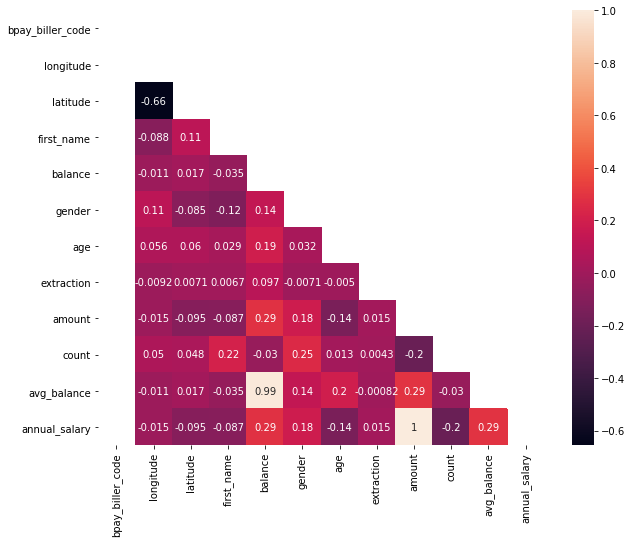

In [6]:
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
corr = file.corr()

fig,ax = plt.subplots(figsize=(10,8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sb.heatmap(corr,mask=mask,annot = True)

**Scatterplots of high scoring features**

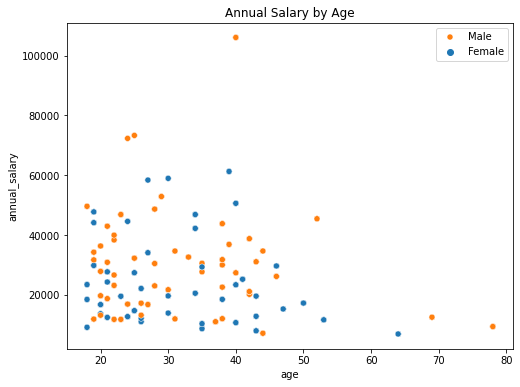

In [7]:
fig,ax = plt.subplots(figsize=(8,6))
sb.scatterplot(data=file,x=file['age'],y=file['annual_salary'],hue=file['gender'])
plt.title("Annual Salary by Age")
plt.legend(['Male','Female'])

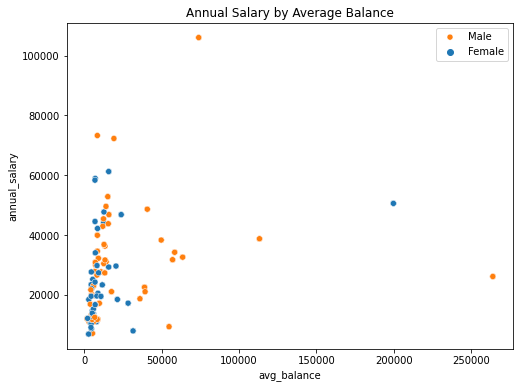

In [8]:
fig,ax = plt.subplots(figsize=(8,6))
sb.scatterplot(data=file,x=file['avg_balance'],y=file['annual_salary'],hue=file['gender'])
plt.title("Annual Salary by Average Balance")
plt.legend(['Male','Female'])

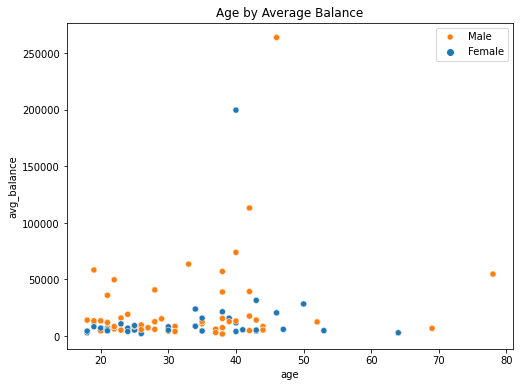

In [9]:
fig,ax = plt.subplots(figsize=(8,6))
sb.scatterplot(data=file,x=file['age'],y=file['avg_balance'],hue=file['gender'])
plt.title("Age by Average Balance")
plt.legend(['Male','Female'])

# Regression Models

**Removing customer id, transaction dates and account numbers**

In [10]:
file = file.drop(['customer_id','account','date','bpay_biller_code'],axis=1)

**Final Dataset**

In [11]:
file.head()

,longitude,latitude,first_name,balance,gender,age,extraction,amount,count,avg_balance,annual_salary
50,151.27,-33.76,30.0,8342.11,1.0,23,1533121200,3903.95,7,15887.912857,46847.40
61,145.01,-37.93,48.0,2040.58,0.0,23,1533124800,1626.48,14,10741.092857,19517.76
64,151.18,-33.80,26.0,3158.51,1.0,22,1533124800,983.36,21,8317.030714,11800.32
68,145.00,-37.83,33.0,2517.66,1.0,24,1533128400,1408.08,13,3877.381429,16896.96
70,144.95,-37.76,41.0,2271.79,0.0,43,1533128400,1068.04,14,5210.705000,12816.48


**Splitting the dataset into inputs and outputs, with the annual salary attribute as the output variable. The datasets are also converted into Numpy Arrays**

In [18]:
input_set = file.iloc[:,0:10]
output_set = file[['annual_salary']]

**Linear Regression Model**

In [77]:
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X_train,X_test,Y_train,Y_test = train_test_split(input_set,output_set,train_size = 0.8, random_state=23)

reg = LinearRegression().fit(X_train,Y_train)

pred = reg.predict(X_test)

scores = cross_validate(reg,Y_test,pred,scoring = ['r2'],cv=3)


print(scores['test_r2'])
print(round(mean_squared_error(Y_test,pred),ndigits=3))

[1. 1. 1.]
0.0


**Regression Plot of Actual Salaries against Predicted Salaries**

Text(0.5, 1.0, 'Actual Salaries vs Predicted Salaries')

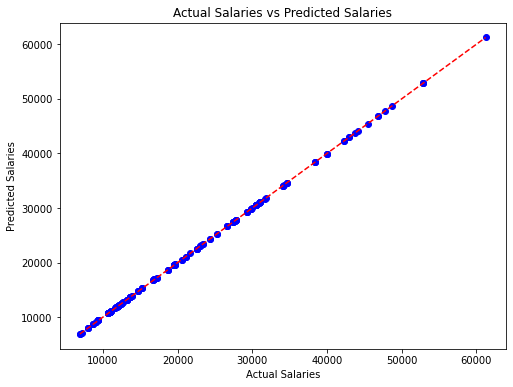

In [78]:
fig,ax = plt.subplots(figsize=(8,6))
plt.scatter(Y_test,pred,color='blue')
plt.plot([Y_test.min(),Y_test.max()],[Y_test.min(),Y_test.max()],'--r')
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Actual Salaries vs Predicted Salaries')

**From the visualisations and error values, we can make the following observations on the Linear Regression model**
1.   The coefficient of determination of the test data is 1.0, which indicates the linear regression model predicts perfect predictions of the annual salaries of ANZ's customers
2.   The mean square error values of the model, given the number of splits as 3, near zero, suggesting a perfect fit between the actual values and the predicted values.



**Decision Tree Regression Model**

In [104]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
tree_X_train,tree_X_test,tree_Y_train,tree_Y_test = train_test_split(input_set,output_set,train_size = 0.8, random_state=23)


tree = DecisionTreeRegressor(max_depth=10).fit(tree_X_train,tree_Y_train)

tree_pred = tree.predict(tree_X_test)

tree_scores = cross_validate(tree,tree_Y_test,tree_pred,scoring = ['r2'],cv=3)

print(tree_scores['test_r2'])
print

[0.99944643 0.99959807 0.99244892]


<function print>

In [100]:
print('RMSE:',np.sqrt(round(mean_squared_error(tree_Y_test,tree_pred),3)))

RMSE: 1.840108692441835


**Regression Plot of Actual Salaries against Predicted Salaries**

Text(0.5, 1.0, 'Actual Salaries vs Predicted Salaries')

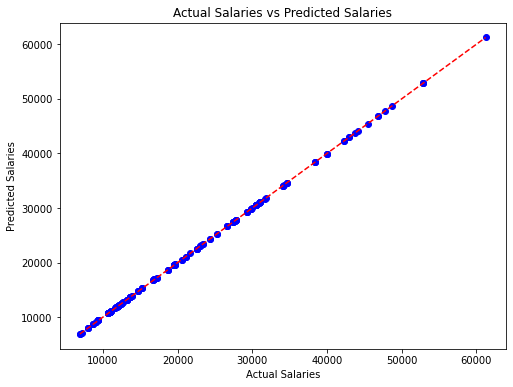

In [97]:
fig,ax = plt.subplots(figsize=(8,6))
plt.scatter(tree_Y_test,tree_pred,color='blue')
plt.plot([tree_Y_test.min(),tree_Y_test.max()],[tree_Y_test.min(),tree_Y_test.max()],'--r')
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Actual Salaries vs Predicted Salaries')

**From the visualisations and error values, we can make the following observations on the Regression Tree model**

1.   The Regression Tree model has a higher root mean square error value than that of the Linear Regression model (RMSE = 1.84).
2.   The r2 scores of the decision tree model are slightly lower than those of the linear regression model, despite the linear plot observing a near perfect fit between the actual salaries and the predicted salaries. 
3. On analysing the plots of the models, we can conclude they display comparably accurate predictions of customers' salaries.

Therefore, we can conclude the two models can be used by ANZ to predict and segment the salaries of its customers, due to the inclusion of new attributes such as the geographical attributes of customers, the number of times each customer received his/her salary during the time period, and so on

